In [ ]:
#安装ChatGLM2-6B
!pip install protobuf
!pip install transformers==4.30.2
!pip install cpm_kernels
!pip install torch>=2.0
!pip install gradio
!pip install mdtex2html
!pip install sentencepiece
!pip install accelerate
!pip install sse-starlette
!pip install streamlit>=1.24.0

#finetune
!pip install -U accelerate
!pip install datasets
!pip install -U peft
!pip install -U torchkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.6/416.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.9 MB/s eta 0:0

In [ ]:
from transformers import  AutoModel,AutoTokenizer
model_name = 'THUDM/chatglm2-6b'
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# 这里将模型转化成了半精度FP16模式，可以显存优化，可以减少模型在GPU上的显存使用量，但可能会牺牲一定的精度
# 如果你希望使用更高的精度，同时你有足够好的GPU你可以移除这个函数的调用
model = AutoModel.from_pretrained(model_name,trust_remote_code=True).half().cuda()

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# define a basic prompt for express comment
# prompt template with 3shots ahead

prompt = """谣言验证任务：将一段网络中流传的文本进行谣言分析，使用逻辑链条的方式对网络文本进行分析，通过step by step的方式给出验证其真伪性的逻辑思路。

下面是一些范例:

A型血更易感染新冠肺炎，O型血不易感 -> 因为研究没有正式发表，没有经过同行评议，所以不应被视为结论性的、指导临床实践/健康相关行为的信息，也不应作为既定事实在新闻媒体报道。 “A、B、O、AB血型与新冠肺炎易感性存在关联”是一个流行病学的研究结果，表述的是血型与病毒感染的相关性，不能简单做出因果关系的解释，也不能过度解读研究结果。另外，该研究中用来作为参考的对照数据，是之前对武汉市3694名正常人的血型调查，这是一个历史数据，这个数据能否真正代表新冠肺炎患者“所属”人群本来应该有的血型分布？是不确定的。 即便血型与病毒感染有相关性，也不能用来指导防疫措施。如果与一个感染者进行了无保护的密切接触，O型血的人被感染仍然是一个大概率事件。
日本医生建议：大量喝水保持喉咙湿润，预防新冠病毒  -> 因为我们常见的疾病，比如感冒、流感、病毒性肺炎主要是通过咳嗽、喷嚏以及空气播散的飞沫在人际间传播。其中上呼吸道中的鼻、咽粘膜上皮细胞是最初的感染部位，也就是咽喉处并不是造成感染的唯一部位。 不可否认喝水对身体的帮助，但是喝水保持咽喉湿润就能预防病毒没有任何依据，咽喉湿润也无法避免病毒会通过上呼吸道进入下呼吸道（支气管、肺部等），15分钟喝一次水更是不切实际。 相对于无孔不入的病毒，保持手卫生更为重要，在接触疑似病人、疑似污染物后，勤洗手，避免不洁净的手直接揉鼻子或眼睛。

请对下述文本进行分析，注意要做到step by step

xxxxxx ->

"""

# replace query with real content

def get_prompt(text):
    return prompt.replace('xxxxxx',text)

In [ ]:
# try for once and test model workable
response, his = model.chat(tokenizer, get_prompt('戴口罩可以吹灭蜡烛打火机火苗，说明口罩不合格'), history=[])
print(response)
print(his)

第一步：阅读文本，理解文本内容。
文本内容：戴口罩可以吹灭蜡烛打火机火苗，说明口罩不合格。

第二步：验证文本内容是否真实。
1. 查找相关资料：通过搜索引擎查询“口罩是否能吹灭蜡烛”和“口罩是否能吹灭打火机火苗”两个问题的结果。
2. 对比结果：与查询结果进行对比，发现两者都是“不可以吹灭蜡烛”和“不可以吹灭打火机火苗”。
3. 结论：根据查询结果，可以得出结论：口罩不可以吹灭蜡烛和打火机火苗。

第三步：验证口罩是否合格。
1. 查找口罩生产标准：查询口罩生产标准，了解口罩合格的判定条件。
2. 对比标准：与口罩生产标准进行对比，发现口罩生产标准通常包括“口罩是否能够有效过滤空气中的颗粒物”、“口罩是否能够防止空气中的颗粒物渗透到口罩内部”等要求。
3. 结论：根据口罩生产标准，可以得出结论：如果口罩能够有效过滤空气中的颗粒物，且不渗透到口罩内部，则口罩是合格的。
[('谣言验证任务：将一段网络中流传的文本进行谣言分析，使用逻辑链条的方式对网络文本进行分析，通过step by step的方式给出验证其真伪性的逻辑思路。\n\n下面是一些范例:\n\nA型血更易感染新冠肺炎，O型血不易感 -> 因为研究没有正式发表，没有经过同行评议，所以不应被视为结论性的、指导临床实践/健康相关行为的信息，也不应作为既定事实在新闻媒体报道。 “A、B、O、AB血型与新冠肺炎易感性存在关联”是一个流行病学的研究结果，表述的是血型与病毒感染的相关性，不能简单做出因果关系的解释，也不能过度解读研究结果。另外，该研究中用来作为参考的对照数据，是之前对武汉市3694名正常人的血型调查，这是一个历史数据，这个数据能否真正代表新冠肺炎患者“所属”人群本来应该有的血型分布？是不确定的。 即便血型与病毒感染有相关性，也不能用来指导防疫措施。如果与一个感染者进行了无保护的密切接触，O型血的人被感染仍然是一个大概率事件。\n日本医生建议：大量喝水保持喉咙湿润，预防新冠病毒  -> 因为我们常见的疾病，比如感冒、流感、病毒性肺炎主要是通过咳嗽、喷嚏以及空气播散的飞沫在人际间传播。其中上呼吸道中的鼻、咽粘膜上皮细胞是最初的感染部位，也就是咽喉处并不是造成感染的唯一部位。 不可否认喝水对身体的帮助，但是喝水保持咽喉湿润就能预防病毒没有任何依据，咽喉湿润也无法避免病毒会通过上呼吸道进入下呼吸道（支气管、肺部等

In [ ]:
# add new history comment as new shots
his.append(("合格的口罩会吸附大量纸屑，反之就是不合格的口罩 -> ","因为在结构完整的情况下，口罩能吸附大量纸屑，主要是靠外层的纺粘布实现的。但真口罩和假口罩最核心的区别在于中间是否有熔喷层（熔喷层是要通过驻极工艺加上静电，静电主要是用来吸附颗粒的）。而熔喷层有静电，不等于口罩外层也有静电。打个比方，我们都知道香蕉肉是甜的，但这不等于说香蕉皮也是甜的，如果不甜就是假香蕉。 事实上，要让口罩外层吸附纸屑很简单，摩擦产生静电即可，但这完全无法说明口罩里是否有熔喷层，以及熔喷层工艺是否合格。"))
# now we got 6 shots
print(his)

[('谣言验证任务：将一段网络中流传的文本进行谣言分析，使用逻辑链条的方式对网络文本进行分析，通过step by step的方式给出验证其真伪性的逻辑思路。\n\n下面是一些范例:\n\nA型血更易感染新冠肺炎，O型血不易感 -> 因为研究没有正式发表，没有经过同行评议，所以不应被视为结论性的、指导临床实践/健康相关行为的信息，也不应作为既定事实在新闻媒体报道。 “A、B、O、AB血型与新冠肺炎易感性存在关联”是一个流行病学的研究结果，表述的是血型与病毒感染的相关性，不能简单做出因果关系的解释，也不能过度解读研究结果。另外，该研究中用来作为参考的对照数据，是之前对武汉市3694名正常人的血型调查，这是一个历史数据，这个数据能否真正代表新冠肺炎患者“所属”人群本来应该有的血型分布？是不确定的。 即便血型与病毒感染有相关性，也不能用来指导防疫措施。如果与一个感染者进行了无保护的密切接触，O型血的人被感染仍然是一个大概率事件。\n日本医生建议：大量喝水保持喉咙湿润，预防新冠病毒  -> 因为我们常见的疾病，比如感冒、流感、病毒性肺炎主要是通过咳嗽、喷嚏以及空气播散的飞沫在人际间传播。其中上呼吸道中的鼻、咽粘膜上皮细胞是最初的感染部位，也就是咽喉处并不是造成感染的唯一部位。 不可否认喝水对身体的帮助，但是喝水保持咽喉湿润就能预防病毒没有任何依据，咽喉湿润也无法避免病毒会通过上呼吸道进入下呼吸道（支气管、肺部等），15分钟喝一次水更是不切实际。 相对于无孔不入的病毒，保持手卫生更为重要，在接触疑似病人、疑似污染物后，勤洗手，避免不洁净的手直接揉鼻子或眼睛。\n\n请对下述文本进行分析，注意要做到step by step\n\n戴口罩可以吹灭蜡烛打火机火苗，说明口罩不合格 ->\n\n', '第一步：阅读文本，理解文本内容。\n文本内容：戴口罩可以吹灭蜡烛打火机火苗，说明口罩不合格。\n\n第二步：验证文本内容是否真实。\n1. 查找相关资料：通过搜索引擎查询“口罩是否能吹灭蜡烛”和“口罩是否能吹灭打火机火苗”两个问题的结果。\n2. 对比结果：与查询结果进行对比，发现两者都是“不可以吹灭蜡烛”和“不可以吹灭打火机火苗”。\n3. 结论：根据查询结果，可以得出结论：口罩不可以吹灭蜡烛和打火机火苗。\n\n第三步：验证口罩是否合格。\n1. 查找口罩生产标准：查询口罩生产标准，了

In [ ]:
# based on new shots to make prediction
response, his = model.chat(tokenizer, "新冠肺炎患者的母乳中有新冠病毒 -> ", history=his)
print(response) # ground truth 为

response, his = model.chat(tokenizer, "新冠病毒会在夏季自行消失 -> ", history=his)
print(response)  # ground truth 为

response, his = model.chat(tokenizer, "宠物狗会传播新型冠状病毒 -> ", history=his)
print(response)  # ground truth 为

目前为止，没有证据表明新冠肺炎患者的母乳中存在新冠病毒。母乳是婴儿出生后最早接触到的食物，如果母乳中存在新冠病毒，那么婴儿接触母乳后感染风险会大大增加。

然而，罩形口罩本身不能完全阻挡住病毒。如果患者在哺乳期间，口罩佩戴不规范或使用低质量的口罩，仍然有可能传播病毒。此外，罩形口罩也无法保证口罩内侧的部位不会被污染。因此，为了确保婴儿的安全，建议使用符合标准的口罩，并规范佩戴和更换。同时，建议在哺乳期间避免与患者近距离接触，以减少感染风险。
目前还没有证据表明新冠病毒会在夏季自行消失。新冠病毒是一种高度传染性的病毒，已经在全球范围内造成了数百万人的感染和数十万人的死亡。虽然新冠病毒的传播能力很强，但它的传染性和致病性也在不断减弱。

一些研究表明，新冠病毒在不同的温度和湿度条件下可能会失去活性，但这种失活并非永久性的。在气温升高和湿度增加的环境下，新冠病毒的传播能力可能会降低，但仍需保持警惕。

此外，新冠病毒的变异也是一个不确定因素。如果新冠病毒在夏季继续传播并变异，那么它可能会更具传染性和致病性。因此，我们应该保持警惕，采取必要的预防措施，以防止新冠病毒的传播。
目前为止，没有证据表明宠物狗会传播新型冠状病毒。

宠物狗是人类的宠物，通常与人类亲密接触。虽然宠物狗可能会携带病毒，但它们通常不会传播新型冠状病毒。此外，许多宠物狗主人都会采取措施，如定期清洁和消毒宠物狗的环境，以防止病毒的传播。

然而，如果宠物狗与感染新冠病毒的人接触，那么宠物狗也可能会被感染。因此，为了确保宠物狗的安全和健康，建议宠物狗主人采取必要的预防措施，如定期清洁和消毒宠物狗的环境，避免与感染新冠病毒的人亲密接触等。


In [ ]:
# define a function for above
# only return prediction result rather than result & history
def predict(text):
    response, history = model.chat(tokenizer, f"{text} ->", history=his,
    temperature=0.01)
    return response

predict('服用阿司匹林能预防新冠肺炎感染') # try for once and got a incompatiable result

'目前为止，没有足够的证据表明服用阿司匹林能够预防新冠肺炎感染。\n\n阿司匹林是一种常见的非处方药，用于缓解疼痛和降低发烧。一些研究表明，阿司匹林可能有助于降低感染新冠病毒的风险。然而，这些研究还需要进一步的证实。\n\n目前，世界卫生组织（WHO）并没有推荐服用阿司匹林来预防新冠肺炎感染。WHO表示，目前没有足够的证据表明阿司匹林或其他药物能够预防新冠病毒感染。此外，服用阿司匹林可能会引起胃肠道不适等不良反应，因此不建议使用。\n\n为了预防新冠病毒感染，我们应该采取其他的预防措施，如佩戴口罩、勤洗手、保持社交距离等。如果感到不适或有疑似症状，应该及时就医并接受检测。'

In [ ]:
# /content/drive/MyDrive/Rumor_Datasets/med_chatglm_rumor_analysis_dataset.json

import pandas as pd
import numpy as np
import datasets

df = pd.read_json("/content/drive/MyDrive/Rumor_Datasets/med_chatglm_rumor_analysis_dataset.json")
df.head()
# print(len(df))

,context,target
0,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,研究没有正式发表，没有经过同行评议，所以不应被视为结论性的、指导临床实践/健康相关行为的信息...
1,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,我们常见的疾病，比如感冒、流感、病毒性肺炎主要是通过咳嗽、喷嚏以及空气播散的飞沫在人际间传播...
2,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,口罩的种类繁多。一部分对于防护性能要求较高的口罩，比如N95、N99等，为了保证防护性，往往...
3,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,在结构完整的情况下，口罩能吸附大量纸屑，主要是靠外层的纺粘布实现的。但真口罩和假口罩最核心的...
4,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,阿昔洛韦是1977年由Elion等人首次设计并合成的无环核苷类似物，并于1981年上市，此后...


In [ ]:
# 将Pandas DataFrame对象转换为Hugging Face Dataset对象
# 将数据集划分为训练集和测试集
# 数据集还是太小了，容易产生过拟合
# test_size: 指定测试集的大小。在这个例子中，测试集的大小是31，这意味着31个样本将被用于测试集
# 已知完整的数据集一共包括124个案例，因此有93个训练集
# shuffle: 如果设置为True，数据集在划分之前会被打乱，可以确保训练集和测试集是随机抽样的，从而避免因样本排序引起的偏差
# seed: 设置随机数生成器的种子，用于控制随机打乱的过程，确保结果是可复制的。在这里，种子被设置为43，你也可以设置为其他的数字
ds_dic = datasets.Dataset.from_pandas(df).train_test_split(
    test_size = 31,shuffle=True, seed = 43)
dftrain = ds_dic['train'].to_pandas() # 将训练集转化为pandas
dftest = ds_dic['test'].to_pandas() # 将验证集转化为pandas
# 用于将DataFrame对象保存为Parquet格式的文件
dftrain.to_parquet('dftrain.parquet')
dftest.to_parquet('dftest.parquet')

In [ ]:
preds = ['' for x in dftest['context']] # 基于测试集的长度创建一个新的数组，用于存储测试的结果
print(len(preds))

31


In [ ]:
dftest['pred'] = preds
dftest.head()

,context,target,pred
0,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,“北京即将封城”、“1月26日晚白岩松将邀请钟南山院士介绍疫情”、“钟南山院士建议：全中国人...,
1,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,钟南山院士并未给出盐水漱口防病毒的建议，广州医科大学附属第一医院已经辟谣。 在生活中我们用盐...,
2,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,N95口罩的使用，美国疾控中心发布了一个文件，指出在特殊情况下（比如口罩供应不足等），可以在...,
3,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,目前市场上所有号称增强免疫力的药物/保健品都缺乏临床依据，比如益生菌、冻干粉等，蘑菇多糖亦是...,
4,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,2020年1月24日，中国医生和科学家关于新型冠状病毒肺炎的诊断治疗经验已经发表在国际顶尖医...,


In [ ]:
# 对dftest中的每一行文本进行预测，然后把预测结果存储在preds列表中
# 使用当前的未经过ft的模型进行评论类型的预测
from tqdm import tqdm
for i in tqdm(range(len(dftest))):
    text = dftest['context'].loc[i]
    preds[i] = predict(text)

100%|██████████| 31/31 [03:50<00:00,  7.43s/it]


In [ ]:
dftest['pred'] = preds
dftest.head()

,context,target,pred
0,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,“北京即将封城”、“1月26日晚白岩松将邀请钟南山院士介绍疫情”、“钟南山院士建议：全中国人...,第一步：阅读文本，理解文本内容。\n文本内容：新型冠状病毒肺炎十大谣言榜。\n\n第二步：验...
1,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,钟南山院士并未给出盐水漱口防病毒的建议，广州医科大学附属第一医院已经辟谣。 在生活中我们用盐...,第一步：阅读文本，理解文本内容。\n文本内容：钟南山院士建议盐水漱口防病毒。\n\n第二步：...
2,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,N95口罩的使用，美国疾控中心发布了一个文件，指出在特殊情况下（比如口罩供应不足等），可以在...,第一步：了解口罩的使用说明。\n根据口罩的使用说明，如果用了7天的N95口罩，可以用吹风机吹...
3,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,目前市场上所有号称增强免疫力的药物/保健品都缺乏临床依据，比如益生菌、冻干粉等，蘑菇多糖亦是...,第一步：阅读文本，理解文本内容。\n文本内容：花菇中的多糖能增强人体免疫力，对抗新型冠状病毒...
4,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,2020年1月24日，中国医生和科学家关于新型冠状病毒肺炎的诊断治疗经验已经发表在国际顶尖医...,第一步：了解背景信息。\n三引号中的内容是一个流传于网络上的谣言，声称“大部分新型肺炎患者只...


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install aspose-words

In [ ]:
!pip install rouge
!pip install sentence_transformers

In [ ]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from sentence_transformers import SentenceTransformer, util

In [ ]:
from nltk.translate.bleu_score import SmoothingFunction

def compute_bleu(target, pred):
    # 将句子转换为字符列表
    reference = [list(target)]
    candidate = list(pred)
    # 使用平滑方法
    smoothie = SmoothingFunction().method1
    return sentence_bleu(reference, candidate, smoothing_function=smoothie)

dftest['bleu'] = dftest.apply(lambda row: compute_bleu(row['target'], row['pred']), axis=1)
bleu_avg = dftest['bleu'].mean()
print('Average BLEU Score:', bleu_avg)



Average BLEU Score: 0.04121983732887678


- 基于Bleu Score作为评价基准还是太牵强了

In [ ]:
rouge = Rouge()

def compute_rouge(target, pred):
    scores = rouge.get_scores(pred, target, avg=True)
    return scores['rouge-l']['f']  # 使用ROUGE-L的F1分数

dftest['rouge'] = dftest.apply(lambda row: compute_rouge(row['target'], row['pred']), axis=1)
rouge_avg = dftest['rouge'].mean()
print('Average ROUGE Score:', rouge_avg)


Average ROUGE Score: 0.0025806450436129088


- 基于rouge作为评价基准依然牵强
- 范围：ROUGE得分的范围是0到1。
- 意义：ROUGE主要是通过对比生成文本和参考文本的n-grams来计算相似度。得分越高，两者的重叠度高。
- 在我们的例子中，我们使用的是ROUGE-L的F1分数，它关注最长的共同子序列。
- 结论：你的ROUGE得分是0.005，这是一个非常低的得分。这意味着你的生成文本和参考文本在n-gram层面上几乎没有重叠。
- 实际上，它们可能在字面上相差很大。

In [ ]:
from sentence_transformers import SentenceTransformer, util

# 使用中文的预训练模型
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

def compute_cosine_similarity(target, pred):
    embedding1 = model.encode(target, convert_to_tensor=True)
    embedding2 = model.encode(pred, convert_to_tensor=True)
    cosine_sim = util.pytorch_cos_sim(embedding1, embedding2)
    return cosine_sim.item()

dftest['cosine_similarity'] = dftest.apply(lambda row: compute_cosine_similarity(row['target'], row['pred']), axis=1)
cosine_avg = dftest['cosine_similarity'].mean()
print('Average Cosine Similarity:', cosine_avg)


Average Cosine Similarity: 0.44413968680366395


- 使用cosine similarity得到了一些较好的结果
- 但也仅仅是较好而已

In [ ]:
dftest.head()

,context,target,pred,bleu,rouge,cosine_similarity
0,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,“北京即将封城”、“1月26日晚白岩松将邀请钟南山院士介绍疫情”、“钟南山院士建议：全中国人...,第一步：阅读文本，理解文本内容。\n文本内容：新型冠状病毒肺炎十大谣言榜。\n\n第二步：验...,0.000753,0.0,0.131680
1,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,钟南山院士并未给出盐水漱口防病毒的建议，广州医科大学附属第一医院已经辟谣。 在生活中我们用盐...,第一步：阅读文本，理解文本内容。\n文本内容：钟南山院士建议盐水漱口防病毒。\n\n第二步：...,0.094533,0.0,0.487034
2,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,N95口罩的使用，美国疾控中心发布了一个文件，指出在特殊情况下（比如口罩供应不足等），可以在...,第一步：了解口罩的使用说明。\n根据口罩的使用说明，如果用了7天的N95口罩，可以用吹风机吹...,0.077778,0.0,0.451866
3,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,目前市场上所有号称增强免疫力的药物/保健品都缺乏临床依据，比如益生菌、冻干粉等，蘑菇多糖亦是...,第一步：阅读文本，理解文本内容。\n文本内容：花菇中的多糖能增强人体免疫力，对抗新型冠状病毒...,0.039456,0.0,0.429607
4,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,2020年1月24日，中国医生和科学家关于新型冠状病毒肺炎的诊断治疗经验已经发表在国际顶尖医...,第一步：了解背景信息。\n三引号中的内容是一个流传于网络上的谣言，声称“大部分新型肺炎患者只...,0.038772,0.0,0.411553


In [ ]:
# 加载数据
import pandas as pd
import numpy as np
import datasets

dftrain = pd.read_parquet('dftrain.parquet')
dftest = pd.read_parquet('dftest.parquet')

In [ ]:
dftrain.head()

,context,target
0,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,有一些初步研究显示乳铁蛋白对于婴儿可能有一定的健康益处，被演绎成了“吃乳铁蛋白增强免疫力”，...
1,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,通过“四名中/轻度患者出院后核酸检测又呈阳性”的案例，并不能直接得出“病毒能在康复者体内存留...
2,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,非典时期，有报道称“洁尔阴”洗剂在体外1:100浓度下能抑制SARS病毒，在当时引起轰动，但...
3,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,新型冠状病毒主要通过飞沫传播，在空调工作状态下飞沫活动范围会明显增大。 虽然目前尚未在空调中...
4,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,首先酒精喷到空气中是无效的。酒精雾化之后，会慢慢挥发，最后成为一个个分子飘散在空气中，这个时...


In [ ]:
dftest.head()

,context,target
0,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,“北京即将封城”、“1月26日晚白岩松将邀请钟南山院士介绍疫情”、“钟南山院士建议：全中国人...
1,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,钟南山院士并未给出盐水漱口防病毒的建议，广州医科大学附属第一医院已经辟谣。 在生活中我们用盐...
2,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,N95口罩的使用，美国疾控中心发布了一个文件，指出在特殊情况下（比如口罩供应不足等），可以在...
3,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,目前市场上所有号称增强免疫力的药物/保健品都缺乏临床依据，比如益生菌、冻干粉等，蘑菇多糖亦是...
4,问题：请分析三引号中的内容进行谣言分析，使用逻辑链条的方式对其进行分析，通过step by ...,2020年1月24日，中国医生和科学家关于新型冠状病毒肺炎的诊断治疗经验已经发表在国际顶尖医...


In [ ]:
# 将上下文整理成与推理时候一致，参照model.chat中的源码
def build_inputs(query, history):
    prompt = ""
    for i, (old_query, response) in enumerate(history):
        prompt += "[Round {}]\n\n问：{}\n\n答：{}\n\n".format(i + 1, old_query, response) # history中的第几轮次，问了什么，得到了什么答案
    prompt += "[Round {}]\n\n问：{} -> \n\n答：".format(len(history) + 1, query) # 当前轮次，当前问话
    return prompt

In [ ]:
print(build_inputs('服用杀虫剂可以杀灭新冠病毒',history=his))

[Round 1]

问：谣言验证任务：将一段网络中流传的文本进行谣言分析，使用逻辑链条的方式对网络文本进行分析，通过step by step的方式给出验证其真伪性的逻辑思路。

下面是一些范例:

A型血更易感染新冠肺炎，O型血不易感 -> 因为研究没有正式发表，没有经过同行评议，所以不应被视为结论性的、指导临床实践/健康相关行为的信息，也不应作为既定事实在新闻媒体报道。 “A、B、O、AB血型与新冠肺炎易感性存在关联”是一个流行病学的研究结果，表述的是血型与病毒感染的相关性，不能简单做出因果关系的解释，也不能过度解读研究结果。另外，该研究中用来作为参考的对照数据，是之前对武汉市3694名正常人的血型调查，这是一个历史数据，这个数据能否真正代表新冠肺炎患者“所属”人群本来应该有的血型分布？是不确定的。 即便血型与病毒感染有相关性，也不能用来指导防疫措施。如果与一个感染者进行了无保护的密切接触，O型血的人被感染仍然是一个大概率事件。
日本医生建议：大量喝水保持喉咙湿润，预防新冠病毒  -> 因为我们常见的疾病，比如感冒、流感、病毒性肺炎主要是通过咳嗽、喷嚏以及空气播散的飞沫在人际间传播。其中上呼吸道中的鼻、咽粘膜上皮细胞是最初的感染部位，也就是咽喉处并不是造成感染的唯一部位。 不可否认喝水对身体的帮助，但是喝水保持咽喉湿润就能预防病毒没有任何依据，咽喉湿润也无法避免病毒会通过上呼吸道进入下呼吸道（支气管、肺部等），15分钟喝一次水更是不切实际。 相对于无孔不入的病毒，保持手卫生更为重要，在接触疑似病人、疑似污染物后，勤洗手，避免不洁净的手直接揉鼻子或眼睛。

请对下述文本进行分析，注意要做到step by step

戴口罩可以吹灭蜡烛打火机火苗，说明口罩不合格 ->



答：第一步：阅读文本，理解文本内容。
文本内容：戴口罩可以吹灭蜡烛打火机火苗，说明口罩不合格。

第二步：验证文本内容是否真实。
1. 查找相关资料：通过搜索引擎查询“口罩是否能吹灭蜡烛”和“口罩是否能吹灭打火机火苗”两个问题的结果。
2. 对比结果：与查询结果进行对比，发现两者都是“不可以吹灭蜡烛”和“不可以吹灭打火机火苗”。
3. 结论：根据查询结果，可以得出结论：口罩不可以吹灭蜡烛和打火机火苗。

第三步：验证口罩是否合格。
1. 查找口罩生产标准：查询口罩生产标准，了解口罩合格的判定条件

In [ ]:
dftrain['context'] = [build_inputs(x,history=his) for x in dftrain['context']] # 定义训练集中的上文
dftrain['target'] = [x for x in dftrain['target']] # 定义训练集中的标签
dftrain = dftrain[['context','target']]

dftest['context'] = [build_inputs(x,history=his) for x in dftest['context']]
dftest['target'] = [x for x in dftest['target']]
dftest = dftest[['context','target']]

In [ ]:
dftrain.head()

,context,target
0,[Round 1]\n\n问：谣言验证任务：将一段网络中流传的文本进行谣言分析，使用逻辑链条...,有一些初步研究显示乳铁蛋白对于婴儿可能有一定的健康益处，被演绎成了“吃乳铁蛋白增强免疫力”，...
1,[Round 1]\n\n问：谣言验证任务：将一段网络中流传的文本进行谣言分析，使用逻辑链条...,通过“四名中/轻度患者出院后核酸检测又呈阳性”的案例，并不能直接得出“病毒能在康复者体内存留...
2,[Round 1]\n\n问：谣言验证任务：将一段网络中流传的文本进行谣言分析，使用逻辑链条...,非典时期，有报道称“洁尔阴”洗剂在体外1:100浓度下能抑制SARS病毒，在当时引起轰动，但...
3,[Round 1]\n\n问：谣言验证任务：将一段网络中流传的文本进行谣言分析，使用逻辑链条...,新型冠状病毒主要通过飞沫传播，在空调工作状态下飞沫活动范围会明显增大。 虽然目前尚未在空调中...
4,[Round 1]\n\n问：谣言验证任务：将一段网络中流传的文本进行谣言分析，使用逻辑链条...,首先酒精喷到空气中是无效的。酒精雾化之后，会慢慢挥发，最后成为一个个分子飘散在空气中，这个时...


In [ ]:
dftest.head()

,context,target
0,[Round 1]\n\n问：谣言验证任务：将一段网络中流传的文本进行谣言分析，使用逻辑链条...,“北京即将封城”、“1月26日晚白岩松将邀请钟南山院士介绍疫情”、“钟南山院士建议：全中国人...
1,[Round 1]\n\n问：谣言验证任务：将一段网络中流传的文本进行谣言分析，使用逻辑链条...,钟南山院士并未给出盐水漱口防病毒的建议，广州医科大学附属第一医院已经辟谣。 在生活中我们用盐...
2,[Round 1]\n\n问：谣言验证任务：将一段网络中流传的文本进行谣言分析，使用逻辑链条...,N95口罩的使用，美国疾控中心发布了一个文件，指出在特殊情况下（比如口罩供应不足等），可以在...
3,[Round 1]\n\n问：谣言验证任务：将一段网络中流传的文本进行谣言分析，使用逻辑链条...,目前市场上所有号称增强免疫力的药物/保健品都缺乏临床依据，比如益生菌、冻干粉等，蘑菇多糖亦是...
4,[Round 1]\n\n问：谣言验证任务：将一段网络中流传的文本进行谣言分析，使用逻辑链条...,2020年1月24日，中国医生和科学家关于新型冠状病毒肺炎的诊断治疗经验已经发表在国际顶尖医...


In [ ]:
# 将pandas的dataset转化为hf的dataset
ds_train = datasets.Dataset.from_pandas(dftrain)
ds_val = datasets.Dataset.from_pandas(dftest)

In [110]:
# 将输入的文本转化为token也就是Tokenizer
# context转化成context_ids，把target转化成target_ids
# 将context_ids和target_ids拼接到一起作为模型的input_ids

from tqdm import tqdm
import transformers

model_name = "THUDM/chatglm2-6b"
max_seq_length = 2048
skip_over_length = True

# 载入模型的Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# 载入模型的参数
config = transformers.AutoConfig.from_pretrained(model_name, trust_remote_code=True, device_map='auto')
# 定义预处理流程
def preprocess(example):
    context = example["context"]
    target = example["target"]
    # 将context转化为id 超长就截取
    context_ids = tokenizer.encode(
            context,
            max_length=max_seq_length,
            truncation=True)
    # 将target也转化为id
    target_ids = tokenizer.encode(
        target,
        max_length=max_seq_length,
        truncation=True,
        add_special_tokens=False)
    # 将上述两者的id拼接 + 配置文件中end of sentence 的id
    input_ids = context_ids + target_ids + [config.eos_token_id]
    # -100标志位后面会在计算loss时会被忽略不贡献损失，我们集中优化target部分生成的loss
    labels = [-100]*len(context_ids)+ target_ids + [config.eos_token_id]

    return {"input_ids": input_ids,
            "labels": labels,
            "context_len": len(context_ids),
            'target_len':len(target_ids)+1}


In [111]:
ds_train_token = ds_train.map(preprocess).select_columns(['input_ids','labels', 'context_len','target_len'])
if skip_over_length:
    ds_train_token = ds_train_token.filter(
        lambda example: example["context_len"]<max_seq_length and example["target_len"]<max_seq_length)
len(ds_train_token)

Map:   0%|          | 0/93 [00:00<?, ? examples/s]

Filter:   0%|          | 0/93 [00:00<?, ? examples/s]

93

In [112]:
ds_val_token = ds_val.map(preprocess).select_columns(['input_ids', 'labels','context_len','target_len'])
if skip_over_length:
    ds_val_token = ds_val_token.filter(
        lambda example: example["context_len"]<max_seq_length and example["target_len"]<max_seq_length)
len(ds_val_token)

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31 [00:00<?, ? examples/s]

31

In [113]:
import torch

def data_collator(examples: list):
    len_ids = [len(example["input_ids"]) for example in examples]
    longest = max(len_ids) #之后按照batch中最长的input_ids进行padding
    input_ids = []
    labels_list = []

    for length, example in sorted(zip(len_ids, examples), key=lambda x: -x[0]):
        ids = example["input_ids"]
        labs = example["labels"]

        ids = ids + [tokenizer.pad_token_id] * (longest - length)
        labs = labs + [-100] * (longest - length)

        input_ids.append(torch.LongTensor(ids))
        labels_list.append(torch.LongTensor(labs))

    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels_list)
    return {
        "input_ids": input_ids,
        "labels": labels,
    }

In [114]:
dl_train = torch.utils.data.DataLoader(ds_train_token,num_workers=2,batch_size=4,
                                       pin_memory=True,shuffle=True,
                                       collate_fn = data_collator)
dl_val = torch.utils.data.DataLoader(ds_val_token,num_workers=2,batch_size=4,
                                    pin_memory=True,shuffle=True,
                                     collate_fn = data_collator)

In [115]:
for batch in dl_train:
    break

In [116]:
batch

{'input_ids': tensor([[64790, 64792,   790,  ..., 54537, 31155,     2],
         [64790, 64792,   790,  ...,     0,     0,     0],
         [64790, 64792,   790,  ...,     0,     0,     0],
         [64790, 64792,   790,  ...,     0,     0,     0]]),
 'labels': tensor([[ -100,  -100,  -100,  ..., 54537, 31155,     2],
         [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
         [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
         [ -100,  -100,  -100,  ...,  -100,  -100,  -100]])}

In [117]:
dl_train.size = 10 #用约10个step做一次验证

In [118]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# 检查设备后开始训练
# for colab tricky issue
# https://github.com/googlecolab/colabtools/issues/3409
!nvidia-smi

Sun Jul 30 04:54:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    51W / 400W |  15263MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [119]:
import warnings
warnings.filterwarnings("ignore")

In [120]:
from transformers import AutoTokenizer, AutoModel, TrainingArguments, AutoConfig
import torch
import torch.nn as nn
from peft import get_peft_model, LoraConfig, TaskType

# 加载ChatGLM2-6B模型并不以8bit的精度载入
model = AutoModel.from_pretrained("THUDM/chatglm2-6b",
                                  load_in_8bit=False,
                                  trust_remote_code=True)

model.supports_gradient_checkpointing = True  #节约cuda，但可能会使得训练时间变长
model.gradient_checkpointing_enable() # 作用同上
model.enable_input_require_grads() # 作用同上

model.config.use_cache = False  # 关闭了模型的缓存机制，该设置可以避免一些警告，但在模型推理时需要重新开启

# 配置LORA模型的类
# 常规LM任务
# 非推理模式
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=8,
    lora_alpha=32, lora_dropout=0.1,
)

# 结合Lora和原有模型
model = get_peft_model(model, peft_config)
# 开启模型的并行处理能力，这可以在有多个GPU的情况下提高训练效率
model.is_parallelizable = True
model.model_parallel = True
# 打印出模型的可训练参数
model.print_trainable_parameters()
# 可训练参数：1949696
# 总参数量：6245533696
# 需要调整的模型参数量的占比还是很低的 3.1%

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

trainable params: 1,949,696 || all params: 6,245,533,696 || trainable%: 0.031217444255383614


In [121]:
from torchkeras import KerasModel
from accelerate import Accelerator
# 重写了torchkeras中的StepRunner类
class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None,
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator()
        if self.stage=='train':
            self.net.train()
        else:
            self.net.eval()

    def __call__(self, batch):

        # 计算loss
        with self.accelerator.autocast():
            # 通过模型self.net对输入数据进行预测，然后用预测结果和标签计算损失, loss的计算过程直接交给ChatGLM2了吗？
            loss = self.net(input_ids=batch["input_ids"],labels=batch["labels"]).loss

        # 执行梯度下降的步骤
        if self.optimizer is not None and self.stage=="train":
            # 计算每个模型参数关于损失的梯度
            self.accelerator.backward(loss)
            # 执行梯度裁剪（self.accelerator.clip_grad_norm_），防止梯度爆炸
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            # 更新模型参数
            self.optimizer.step()
            # 存在学习率调整器，就调整学习率
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            # 清空梯度
            self.optimizer.zero_grad()

        # 给并行计算和多GPU计算的损失收集起来并求和
        all_loss = self.accelerator.gather(loss).sum()

        # losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}

        # metrics (stateful metrics)
        step_metrics = {}

        # 记录过程信息，追踪模型性能用
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics

KerasModel.StepRunner = StepRunner

# 仅仅保存lora可训练参数
# 覆盖了KerasModel中的load_ckpt和save_ckpt方法
def save_ckpt(self, ckpt_path='checkpoint.pt', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)

def load_ckpt(self, ckpt_path='checkpoint.pt'):
    self.net = self.net.from_pretrained(self.net,ckpt_path)
    self.from_scratch = False

KerasModel.save_ckpt = save_ckpt
KerasModel.load_ckpt = load_ckpt


In [122]:
# 定义模型的训练
# 没有损失函数
# 优化器是adamW
# 学习率 2e-6
# 模型参数存储路径
keras_model = KerasModel(model,loss_fn = None,
        optimizer=torch.optim.AdamW(model.parameters(),lr=2e-6))
ckpt_path = 'medical_rumor_chatglm2_v2'

<<<<<< ⚡️ cuda is used >>>>>>


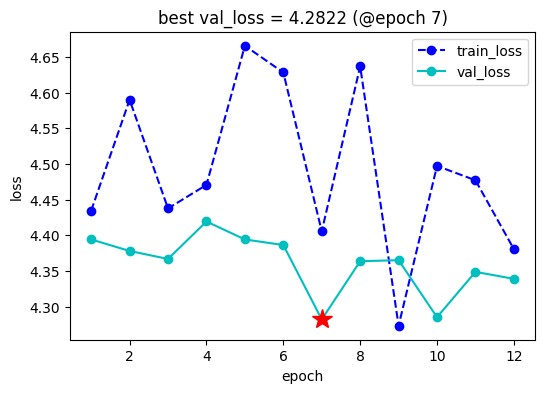

<<<<<< val_loss without improvement in 5 epoch,early stopping >>>>>>


,epoch,train_loss,lr,val_loss
0,1,4.434570,0.000002,4.394287
1,2,4.589844,0.000002,4.378174
2,3,4.437695,0.000002,4.366943
3,4,4.470703,0.000002,4.419434
4,5,4.665625,0.000002,4.394287
5,6,4.628125,0.000002,4.386475
6,7,4.405664,0.000002,4.282227
7,8,4.636719,0.000002,4.363770
8,9,4.273438,0.000002,4.365234
9,10,4.497266,0.000002,4.285400


In [123]:
# 训练一百轮
# patience=5：早停策略的参数，用于防止模型在训练过程中过拟合。如果在连续的5轮训练中，验证损失（或者其他的指定指标）都没有改善，那么训练将会提前停止
# monitor='val_loss'：需要监控的指标：验证损失
# mode='min'：早停策略的参数，指定了改进的方向。'min'意味着指标（这里是验证损失）的最小值被视为改进
# mixed_precision='fp16'：这是一种混合精度训练的策略。在混合精度训练中，一部分张量的数据类型会被设为低精度（如半精度浮点数fp16），这样可以减少计算资源的需求，从而提高训练速度和效率
keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=100,patience=5,
                monitor='val_loss',mode='min',
                ckpt_path = ckpt_path,
                mixed_precision='fp16'
               )

In [124]:
from peft import PeftModel
model = AutoModel.from_pretrained("THUDM/chatglm2-6b",
                                  load_in_8bit=False,
                                  trust_remote_code=True,
                                  device_map='auto')
model = PeftModel.from_pretrained(model,ckpt_path)
model = model.merge_and_unload() #合并lora权重

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [125]:
predict('服用老鼠药可以治疗艾滋病')

'服用老鼠药无法治疗艾滋病。\n\n艾滋病是一种由人类免疫缺陷病毒（HIV）引起的疾病，它攻击人体的免疫系统，导致人体无法抵抗疾病。目前，没有药物可以完全治愈艾滋病，但可以控制疾病的进展并提高生活质量。\n\n老鼠药是用于杀死老鼠的化学物质，它与艾滋病没有直接关系。服用老鼠药无法治疗艾滋病，而且使用老鼠药还可能对人体和环境造成危害。\n\n如果感到身体不适或者担心自己的健康状况，建议及时就医，接受专业的医疗建议和治疗。'

In [128]:
dftest = pd.read_parquet('dftest.parquet')
preds = ['' for x in dftest['context']]
# 重新走一遍对测试数据的验证流程
from tqdm import tqdm
for i in tqdm(range(len(dftest))):
    text = dftest['target'].loc[i]
    preds[i] = predict(text)

100%|██████████| 31/31 [02:49<00:00,  5.47s/it]


In [129]:
dftest['pred'] = preds

In [131]:
from sentence_transformers import SentenceTransformer, util

# 使用中文的预训练模型
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

def compute_cosine_similarity(target, pred):
    embedding1 = model.encode(target, convert_to_tensor=True)
    embedding2 = model.encode(pred, convert_to_tensor=True)
    cosine_sim = util.pytorch_cos_sim(embedding1, embedding2)
    return cosine_sim.item()

dftest['cosine_similarity'] = dftest.apply(lambda row: compute_cosine_similarity(row['target'], row['pred']), axis=1)
cosine_avg = dftest['cosine_similarity'].mean()
print('Average Cosine Similarity:', cosine_avg)


Average Cosine Similarity: 0.7436385789225178
